# Data Processing
*Author: Paulo Medina*
## Datasets
| Dataset name | Source | Type |
| --- | --- | --- |
| FIRMS Fire Events | NASA - MODIS | Geometry (Point) |
| Paraguay Administrative Boundaries | Paraguayan Statistical Institute | Geometry (Polygon) |
| Protected Areas Boundaries | WPAD | Geometry (Polygon) |
| Human Settlements | Paraguayan Statistical Institute | Geometry (Point) |
| Roads | Paraguayan Statistical Institute | Geometry (Lines) |
| Fire Risk Area | Derived | Geometry (Polygon) |

All data will prepared and limited to the Chaco region.


In [35]:
# Load all necessary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from geoalchemy2 import Geography
from sqlalchemy import text

In [36]:
# Table names list for PostGIS
tables = {}
queries = {}
# Updated Mapping
dtype_mapping = {
    'int64': 'INTEGER',
    'int32': 'INTEGER',
    'float64': 'DOUBLE PRECISION', # Better than DECIMAL for scientific/GIS data
    'datetime64[ns]': 'TIMESTAMP',
    'object': 'TEXT' # Use TEXT in Postgres instead of VARCHAR(255) to avoid truncation
}

def generate_sql_schema(gdf, table_name):
    srid = 32720
    table = table_name.replace('_', ' ').title()
    sql = f"\n-- {table}\nCREATE TABLE {table_name} (\n    {table_name}_id SERIAL PRIMARY KEY,\n"
    tables[table_name] = gdf
    
    has_geometry = False
    
    for col, dtype in gdf.dtypes.items():
        if col == 'geometry':
            has_geometry = True
            raw_geom_type = str(gdf.geometry.geom_type.unique()[0]).upper()
            sql_dtype = f"GEOMETRY({raw_geom_type}, {srid})"
        else:
            sql_dtype = dtype_mapping.get(str(dtype))
            
        sql += f"    {col} {sql_dtype},\n"
    
    sql = sql.rstrip(',\n') + "\n);\n"
    
    # Add spatial index if geometry exists
    if has_geometry:
        sql += f"CREATE INDEX idx_{table_name}_geom ON {table_name} USING GIST(geometry);\n"
    
    queries[table_name] = sql
    return sql

In [37]:
# Display first 5 rows of the GeoDataFrame and get length of data
def display_gdf_info(gdf, name):
    print(f"Length of {name} GeoDataFrame: {len(gdf)}")
    print(f"\nData types in {name} GeoDataFrame:")
    print(gdf.dtypes)
    print(gdf.head(5))
    gdf.plot()

### Chaco Region Administrative Boundaries

All geographic data will be clipped to these boundaries.

Length of Paraguay Boundaries GeoDataFrame: 17

Data types in Paraguay Boundaries GeoDataFrame:
ADM0_CODE        int64
ADM0_NAME       object
ADM1_CODE        int64
ADM1_NAME       object
DISP_AREA       object
EXP1_YEAR        int64
STATUS          object
STR1_YEAR        int64
Shape_Area     float64
Shape_Leng     float64
geometry      geometry
dtype: object
   ADM0_CODE ADM0_NAME  ADM1_CODE      ADM1_NAME DISP_AREA  EXP1_YEAR  \
0        194  Paraguay       2311  Alto Paraguay        NO       3000   
1        194  Paraguay       2312    Alto Parana        NO       3000   
2        194  Paraguay       2313        Amambay        NO       3000   
3        194  Paraguay       2314       Boqueron        NO       3000   
4        194  Paraguay       2315       Caaguazu        NO       3000   

         STATUS  STR1_YEAR  Shape_Area  Shape_Leng  \
0  Member State       1000    6.785640   13.908306   
1  Member State       1000    1.264466    7.937863   
2  Member State       1000    1.1147

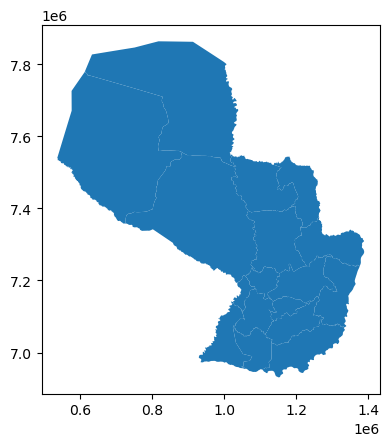

In [38]:
# Ingest data
# Convert to GeoDataFrame
pry_boundaries_gdf = gpd.read_file('raw/boundaries/Paraguay_bnd.shp')
pry_boundaries_gdf.to_crs(epsg=32720, inplace=True)

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(pry_boundaries_gdf, "Paraguay Boundaries")

<Axes: >

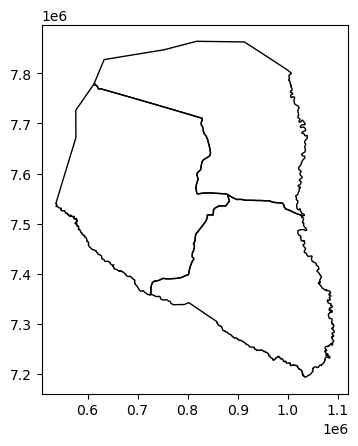

In [39]:
# Mask to get only Chaco region
chaco_mask = pry_boundaries_gdf['ADM1_NAME'].apply(lambda x: x in ['Alto Paraguay', 'Boqueron', 'Presidente Hayes'])
# Extract data by mask
chaco_boundaries = pry_boundaries_gdf[chaco_mask].copy()
del(pry_boundaries_gdf) # Remove full dataset

chaco_boundaries.plot(edgecolor='black', facecolor='none')

In [40]:
# Clean data
# Remove unused columns
chaco_boundaries.drop(columns=['ADM0_CODE', 'ADM0_NAME', 'DISP_AREA', 'EXP1_YEAR', 'STATUS', 'STR1_YEAR'], inplace=True)

# Calculate area in square kilometers
chaco_boundaries['area_km2'] = chaco_boundaries.geometry.to_crs(epsg=32720).area / 10**6

chaco_boundaries = chaco_boundaries[['ADM1_CODE','ADM1_NAME', 'area_km2', 'geometry']]

In [41]:
chaco_boundaries_query = generate_sql_schema(chaco_boundaries, 'chaco_boundaries')
print(chaco_boundaries_query)


-- Chaco Boundaries
CREATE TABLE chaco_boundaries (
    chaco_boundaries_id SERIAL PRIMARY KEY,
    ADM1_CODE INTEGER,
    ADM1_NAME TEXT,
    area_km2 DOUBLE PRECISION,
    geometry GEOMETRY(POLYGON, 32720)
);
CREATE INDEX idx_chaco_boundaries_geom ON chaco_boundaries USING GIST(geometry);



### Load and clip all layers to the Chaco

In [42]:
# Function to clip features to Chaco region
def clip_to_chaco(gdf):
    gdf_clipped = gpd.clip(gdf, chaco_boundaries)
    return gdf_clipped

### Admin 2 level boundaries

Length of Chaco Districts GeoDataFrame: 21

Data types in Chaco Districts GeoDataFrame:
ADM0_ES         object
ADM0_PCODE      object
ADM1_ES         object
ADM1_PCODE      object
ADM2_ES         object
ADM2_PCODE      object
geometry      geometry
dtype: object
      ADM0_ES ADM0_PCODE           ADM1_ES ADM1_PCODE  \
234  Paraguay         PY  PRESIDENTE HAYES       PY15   
235  Paraguay         PY  PRESIDENTE HAYES       PY15   
231  Paraguay         PY  PRESIDENTE HAYES       PY15   
238  Paraguay         PY  PRESIDENTE HAYES       PY15   
233  Paraguay         PY  PRESIDENTE HAYES       PY15   

                        ADM2_ES ADM2_PCODE  \
234                      NANAWA     PY1505   
235                 JOSÉ FALCÓN     PY1506   
231             BENJAMÍN ACEVAL     PY1502   
238  GENERAL JOSÉ MARÍA BRUGUEZ     PY1509   
233                 VILLA HAYES     PY1504   

                                              geometry  
234  MULTIPOLYGON (((1033428.009 7194659.665, 10334...  
235

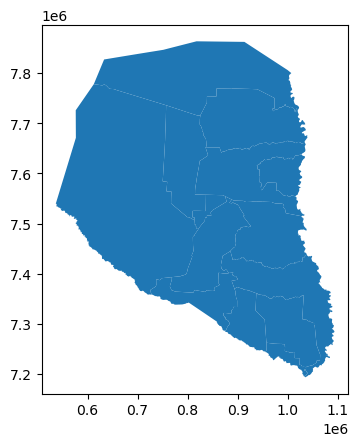

In [43]:
# Ingest data
# Convert to GeoDataFrame
pry_districts_gdf = gpd.read_file('raw/boundaries/pry_admbnda_adm2_DGEEC_2020.shp')
pry_districts_gdf.to_crs(epsg=32720, inplace=True)

# Remove unused columns
# pry_districts_gdf.drop(columns=['fid','DPTO','DISTRITO', 'DPTO_DESC','AREA','DIST_DESC', 'RODA_VIA', 'Long_Metro'], inplace=True)
#Clip to Chaco region
chaco_districts = clip_to_chaco(pry_districts_gdf.copy())

del(pry_districts_gdf) # Remove full dataset

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(chaco_districts, "Chaco Districts")

In [44]:
chaco_districts_query = generate_sql_schema(chaco_districts, 'chaco_districts')
print(chaco_districts_query)


-- Chaco Districts
CREATE TABLE chaco_districts (
    chaco_districts_id SERIAL PRIMARY KEY,
    ADM0_ES TEXT,
    ADM0_PCODE TEXT,
    ADM1_ES TEXT,
    ADM1_PCODE TEXT,
    ADM2_ES TEXT,
    ADM2_PCODE TEXT,
    geometry GEOMETRY(MULTIPOLYGON, 32720)
);
CREATE INDEX idx_chaco_districts_geom ON chaco_districts USING GIST(geometry);



### FIRMS Fire Data

Length of Fire Events GeoDataFrame: 2612

Data types in Fire Events GeoDataFrame:
latitude             float64
longitude            float64
acq_date      datetime64[ns]
bright_t31           float64
brightness           float64
confidence             int64
track                float64
instrument            object
scan                 float64
satellite             object
geometry            geometry
dtype: object
      latitude  longitude   acq_date  bright_t31  brightness  confidence  \
1413 -24.96237  -58.14286 2025-08-18      298.90      317.77          71   
2803 -24.90294  -58.33410 2025-09-06      289.90      304.58          30   
3008 -24.83335  -58.22136 2025-09-10      302.44      318.76          69   
4347 -25.00396  -57.91813 2025-09-25      296.78      310.56          64   
2565 -24.99997  -57.94125 2025-08-31      301.05      332.86          85   

      track instrument  scan satellite                         geometry  
1413   1.40      MODIS  2.06      Aqua   POINT (990662

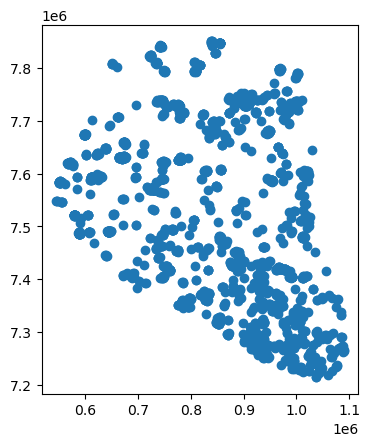

In [45]:
# Ingest data
fire_events_df = pd.read_json('raw/fire_events/fire_nrt_M-C61_676512.json') # Read JSON file into a standard DataFrame

# Convert to GeoDataFrame
fire_events_gdf = gpd.GeoDataFrame( 
    fire_events_df, geometry=gpd.points_from_xy(fire_events_df.longitude, fire_events_df.latitude))
fire_events_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)
fire_events_gdf.to_crs(epsg=32720, inplace=True)
fire_events_gdf = clip_to_chaco(fire_events_gdf)
# Remove standard DataFrame to free up memory
del(fire_events_df)

# Clean data
# Remove rows with null geometry
fire_events_gdf = fire_events_gdf[fire_events_gdf.geometry.notnull()]
# Remove unused columns
fire_events_gdf.drop(columns=['version', 'daynight', 'frp', 'acq_time'], inplace=True)
# Convert acq_date to datetime
fire_events_gdf['acq_date'] = pd.to_datetime(fire_events_gdf['acq_date'], format='%Y-%m-%d')

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(fire_events_gdf, "Fire Events")

In [46]:
fire_events_query = generate_sql_schema(fire_events_gdf, 'fire_events')
print(fire_events_query)


-- Fire Events
CREATE TABLE fire_events (
    fire_events_id SERIAL PRIMARY KEY,
    latitude DOUBLE PRECISION,
    longitude DOUBLE PRECISION,
    acq_date TIMESTAMP,
    bright_t31 DOUBLE PRECISION,
    brightness DOUBLE PRECISION,
    confidence INTEGER,
    track DOUBLE PRECISION,
    instrument TEXT,
    scan DOUBLE PRECISION,
    satellite TEXT,
    geometry GEOMETRY(POINT, 32720)
);
CREATE INDEX idx_fire_events_geom ON fire_events USING GIST(geometry);



### Roads

Length of Chaco Roads GeoDataFrame: 22547

Data types in Chaco Roads GeoDataFrame:
NOMBRE          object
TIPO_VIA        object
DesTipoVia      object
DesRodaVia      object
geometry      geometry
dtype: object
      NOMBRE TIPO_VIA    DesTipoVia DesRodaVia  \
75793   None        7  Camino Rural     Tierra   
75791   None        7  Camino Rural     Tierra   
75790   None        7  Camino Rural     Tierra   
75997   None        7  Camino Rural     Tierra   
75695   None        7  Camino Rural     Tierra   

                                                geometry  
75793  LINESTRING (936733.999 7249198.747, 936783.023...  
75791  LINESTRING (936928.733 7250451.513, 936906.28 ...  
75790  LINESTRING (936761.654 7250480.924, 936786.619...  
75997  LINESTRING (935370.599 7252885.902, 935740.765...  
75695  LINESTRING (938963.964 7254794.371, 938958.12 ...  


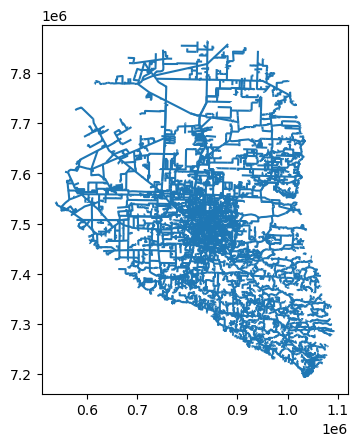

In [47]:
# Ingest data
# Convert to GeoDataFrame
pry_roads_gdf = gpd.read_file('raw/Vias/V_as_Paraguay_INE_20221.shp')
pry_roads_gdf.to_crs(epsg=32720, inplace=True)

# Remove unused columns
pry_roads_gdf.drop(columns=['fid','DPTO','DISTRITO', 'DPTO_DESC','AREA','DIST_DESC', 'RODA_VIA', 'Long_Metro'], inplace=True)

#Clip to Chaco region
chaco_roads = clip_to_chaco(pry_roads_gdf.copy())

del(pry_roads_gdf) # Remove full dataset

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(chaco_roads, "Chaco Roads")

In [48]:
chaco_roads_query = generate_sql_schema(chaco_roads, 'chaco_roads')
print(chaco_roads_query)


-- Chaco Roads
CREATE TABLE chaco_roads (
    chaco_roads_id SERIAL PRIMARY KEY,
    NOMBRE TEXT,
    TIPO_VIA TEXT,
    DesTipoVia TEXT,
    DesRodaVia TEXT,
    geometry GEOMETRY(LINESTRING, 32720)
);
CREATE INDEX idx_chaco_roads_geom ON chaco_roads USING GIST(geometry);



### Water bodies

Length of Chaco Rivers GeoDataFrame: 523

Data types in Chaco Rivers GeoDataFrame:
NOMBRE        object
geometry    geometry
dtype: object
              NOMBRE                                           geometry
23223  Rio Pilcomayo  MULTILINESTRING ((1016981.619 7216495.994, 101...
23222  Rio Pilcomayo  MULTILINESTRING ((1016981.619 7216495.994, 101...
22294  Rio Pilcomayo  MULTILINESTRING ((1032321.967 7195019.09, 1032...
5474    Rio Paraguay  LINESTRING (1036138.12 7193851.146, 1036153.36...
5487   Rio Pilcomayo  LINESTRING (1035451.477 7193309.781, 1035457.5...


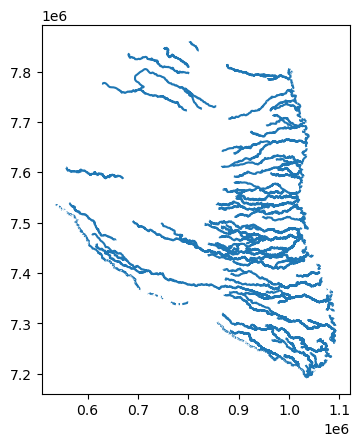

In [49]:
# Ingest data
# Convert to GeoDataFrame
pry_rivers_gdf = gpd.read_file('raw/Hidrografia/Hidrografia.shp')
pry_rivers_gdf.to_crs(epsg=32720, inplace=True)

# Clip to Chaco region
chaco_rivers = clip_to_chaco(pry_rivers_gdf.copy())
del(pry_rivers_gdf) # Remove full dataset

# Remove unused columns
chaco_rivers.drop(columns=['fid'], inplace=True)

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(chaco_rivers, "Chaco Rivers")

In [50]:
chaco_rivers_query = generate_sql_schema(chaco_rivers, 'chaco_rivers')
print(chaco_rivers_query)


-- Chaco Rivers
CREATE TABLE chaco_rivers (
    chaco_rivers_id SERIAL PRIMARY KEY,
    NOMBRE TEXT,
    geometry GEOMETRY(MULTILINESTRING, 32720)
);
CREATE INDEX idx_chaco_rivers_geom ON chaco_rivers USING GIST(geometry);



### Protected Areas

<Axes: >

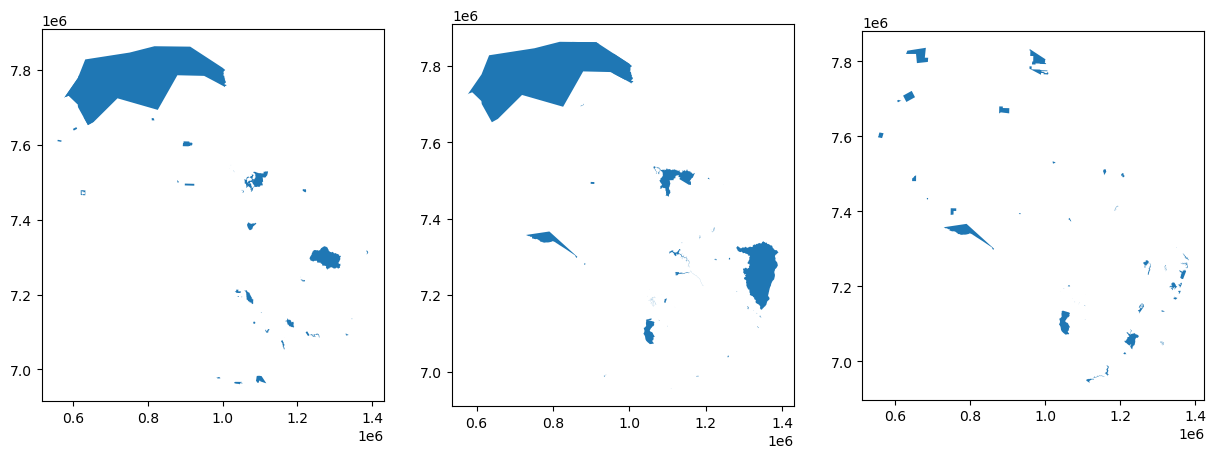

In [51]:
# Data obtained from: https://www.protectedplanet.net/country/PRY
pry_wpda_gdf_1 = gpd.read_file('raw/boundaries/WDPA_WDOECM_Jan2026_Public_PRY_shp_0/WDPA_WDOECM_Jan2026_Public_PRY_shp-polygons.shp')
pry_wpda_gdf_2 = gpd.read_file('raw/boundaries/WDPA_WDOECM_Jan2026_Public_PRY_shp_1/WDPA_WDOECM_Jan2026_Public_PRY_shp-polygons.shp')
pry_wpda_gdf_3 = gpd.read_file('raw/boundaries/WDPA_WDOECM_Jan2026_Public_PRY_shp_2/WDPA_WDOECM_Jan2026_Public_PRY_shp-polygons.shp')
pry_wpda_gdf_1.to_crs(epsg=32720, inplace=True)
pry_wpda_gdf_2.to_crs(epsg=32720, inplace=True)
pry_wpda_gdf_3.to_crs(epsg=32720, inplace=True)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

pry_wpda_gdf_1.plot(ax=ax[0])
pry_wpda_gdf_2.plot(ax=ax[1])
pry_wpda_gdf_3.plot(ax=ax[2])

Length of Chaco Protected Areas GeoDataFrame: 31

Data types in Chaco Protected Areas GeoDataFrame:
NAME_ENG        object
NAME            object
DESIG           object
DESIG_ENG       object
DESIG_TYPE      object
IUCN_CAT        object
INT_CRIT        object
REALM           object
REP_M_AREA     float64
REP_AREA       float64
GIS_AREA       float64
NO_TAKE         object
NO_TK_AREA     float64
GOV_TYPE        object
GOVSUBTYPE      object
OWN_TYPE        object
OWNSUBTYPE      object
MANG_AUTH       object
ISO3            object
SUPP_INFO       object
CONS_OBJ        object
geometry      geometry
dtype: object
                    NAME_ENG                     NAME              DESIG  \
88                 Toldo Cue                Toldo Cue    Reserva Natural   
71                 Tinfunque                Tinfunque  Sitio Ramsar 1995   
94   Coronel Valóis Rivarola  Coronel Valóis Rivarola    Reserva Natural   
131               Toro Mocho               Toro Mocho    Reserva Privada   


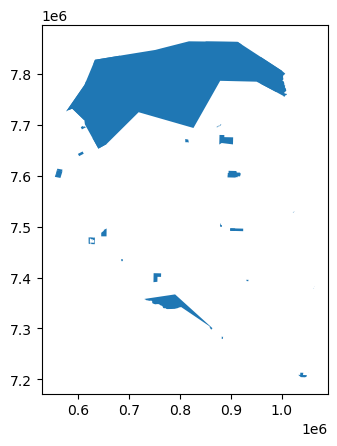

In [52]:
# Append all three GeoDataFrames
pry_wpda_gdf = pd.concat([pry_wpda_gdf_1, pry_wpda_gdf_2, pry_wpda_gdf_3], ignore_index=True)

# Remove duplicates based on 'WDPAID'
pry_wpda_gdf.drop_duplicates(subset=['NAME_ENG'], inplace=True)


# Remove unused columns
pry_wpda_gdf.drop(columns=['SITE_ID', 'SITE_PID', 'SITE_TYPE', 'MANG_PLAN', 'METADATAID', 'PRNT_ISO3', 'INLND_WTRS', 'OECM_ASMT', 'GIS_M_AREA', 'STATUS_YR', 'STATUS', 'VERIF'], inplace=True)

# Clip to Chaco region
chaco_protected_areas = clip_to_chaco(pry_wpda_gdf.copy())
del(pry_wpda_gdf) # Remove full dataset

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(chaco_protected_areas, "Chaco Protected Areas")

In [53]:
chaco_protected_areas_query = generate_sql_schema(chaco_protected_areas, 'chaco_protected_areas')
print(chaco_protected_areas_query)


-- Chaco Protected Areas
CREATE TABLE chaco_protected_areas (
    chaco_protected_areas_id SERIAL PRIMARY KEY,
    NAME_ENG TEXT,
    NAME TEXT,
    DESIG TEXT,
    DESIG_ENG TEXT,
    DESIG_TYPE TEXT,
    IUCN_CAT TEXT,
    INT_CRIT TEXT,
    REALM TEXT,
    REP_M_AREA DOUBLE PRECISION,
    REP_AREA DOUBLE PRECISION,
    GIS_AREA DOUBLE PRECISION,
    NO_TAKE TEXT,
    NO_TK_AREA DOUBLE PRECISION,
    GOV_TYPE TEXT,
    GOVSUBTYPE TEXT,
    OWN_TYPE TEXT,
    OWNSUBTYPE TEXT,
    MANG_AUTH TEXT,
    ISO3 TEXT,
    SUPP_INFO TEXT,
    CONS_OBJ TEXT,
    geometry GEOMETRY(POLYGON, 32720)
);
CREATE INDEX idx_chaco_protected_areas_geom ON chaco_protected_areas USING GIST(geometry);



### Risk Surface

Length of Risk Surface GeoDataFrame: 5533

Data types in Risk Surface GeoDataFrame:
id              object
count            int32
risk_level       int32
geometry      geometry
dtype: object
            id  count  risk_level  \
0  +1075+15080      2           2   
1  +1076+15069      3           2   
2  +1110+15169      3           2   
3  +1111+15080     10           2   
4  +1111+15102      1           2   

                                            geometry  
0  POLYGON ((537000 7540500, 537000 7540000, 5380...  
1  POLYGON ((537500 7535000, 537500 7534000, 5380...  
2  MULTIPOLYGON (((555500 7584500, 555500 7584000...  
3  POLYGON ((554500 7539500, 554500 7539000, 5565...  
4  POLYGON ((555500 7551500, 555500 7551000, 5560...  


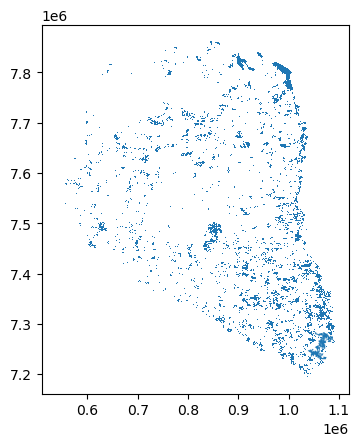

In [54]:
# Load risk surface
risk_surface_gdf = gpd.read_file('raw/Risk/Chaco_Wildfire_Risk_Vectors.geojson')
risk_surface_gdf.to_crs(epsg=32720, inplace=True)

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(risk_surface_gdf, "Risk Surface")

In [55]:
risk_surface_gdf_query = generate_sql_schema(risk_surface_gdf, 'risk_surface')
print(risk_surface_gdf_query)


-- Risk Surface
CREATE TABLE risk_surface (
    risk_surface_id SERIAL PRIMARY KEY,
    id TEXT,
    count INTEGER,
    risk_level INTEGER,
    geometry GEOMETRY(POLYGON, 32720)
);
CREATE INDEX idx_risk_surface_geom ON risk_surface USING GIST(geometry);



### Households

#### Presidente Hayes

Length of Presidente Hayes households GeoDataFrame: 34676

Data types in Presidente Hayes households GeoDataFrame:
id              object
fid              int32
DPTO            object
DPTO_DESC       object
DISTRITO        object
DIST_DESC       object
AREA            object
BAR_LOC         object
BARLO_DESC      object
geometry      geometry
dtype: object
                id  fid DPTO         DPTO_DESC DISTRITO        DIST_DESC AREA  \
0  VIVIENDAS_150.1    1   15  PRESIDENTE HAYES       02  BENJAMIN ACEVAL    6   
1  VIVIENDAS_150.2    2   15  PRESIDENTE HAYES       02  BENJAMIN ACEVAL    6   
2  VIVIENDAS_150.3    3   15  PRESIDENTE HAYES       02  BENJAMIN ACEVAL    6   
3  VIVIENDAS_150.4    4   15  PRESIDENTE HAYES       02  BENJAMIN ACEVAL    6   
4  VIVIENDAS_150.5    5   15  PRESIDENTE HAYES       02  BENJAMIN ACEVAL    6   

  BAR_LOC       BARLO_DESC                         geometry  
0     110  ASENT. SAN JOSE  POINT (1048996.443 7222489.634)  
1     110  ASENT. SAN JOSE  PO

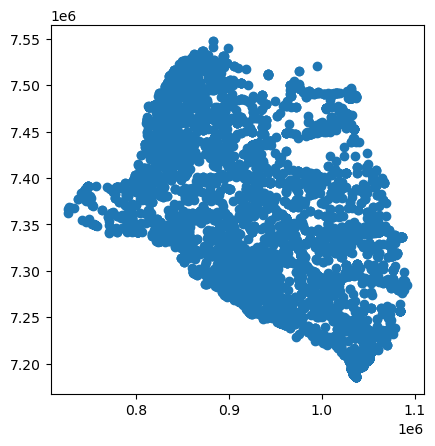

In [56]:
# Load risk surface
households_pa_gdf = gpd.read_file('raw/households/viviendas_presidente_hayes.geojson')
households_pa_gdf.to_crs(epsg=32720, inplace=True)

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(households_pa_gdf, "Presidente Hayes households")

In [57]:
households_pa_gdf_query = generate_sql_schema(households_pa_gdf, 'pa_households')
print(households_pa_gdf_query)


-- Pa Households
CREATE TABLE pa_households (
    pa_households_id SERIAL PRIMARY KEY,
    id TEXT,
    fid INTEGER,
    DPTO TEXT,
    DPTO_DESC TEXT,
    DISTRITO TEXT,
    DIST_DESC TEXT,
    AREA TEXT,
    BAR_LOC TEXT,
    BARLO_DESC TEXT,
    geometry GEOMETRY(POINT, 32720)
);
CREATE INDEX idx_pa_households_geom ON pa_households USING GIST(geometry);



#### Boqueron

Length of Boqueron households GeoDataFrame: 17274

Data types in Boqueron households GeoDataFrame:
id              object
fid              int32
DPTO            object
DPTO_DESC       object
DISTRITO        object
DIST_DESC       object
AREA            object
BAR_LOC         object
BARLO_DESC      object
geometry      geometry
dtype: object
                id  fid DPTO DPTO_DESC DISTRITO  \
0  VIVIENDAS_160.1    1   16  BOQUERON       02   
1  VIVIENDAS_160.2    2   16  BOQUERON       02   
2  VIVIENDAS_160.3    3   16  BOQUERON       02   
3  VIVIENDAS_160.4    4   16  BOQUERON       02   
4  VIVIENDAS_160.5    5   16  BOQUERON       02   

                          DIST_DESC AREA BAR_LOC                  BARLO_DESC  \
0  MARISCAL JOSE FELIX ESTIGARRIBIA    3     205  ZONA POZO HONDO SUB-URBANO   
1  MARISCAL JOSE FELIX ESTIGARRIBIA    3     205  ZONA POZO HONDO SUB-URBANO   
2  MARISCAL JOSE FELIX ESTIGARRIBIA    3     205  ZONA POZO HONDO SUB-URBANO   
3  MARISCAL JOSE FELIX ESTIGAR

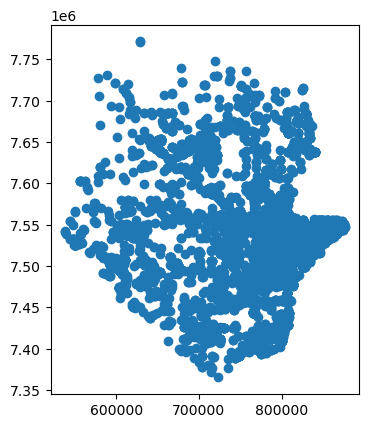

In [58]:
# Load risk surface
households_boqueron_gdf = gpd.read_file('raw/households/viviendas_boqueron.geojson')
households_boqueron_gdf.to_crs(epsg=32720, inplace=True)

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(households_boqueron_gdf, "Boqueron households")

In [59]:
households_boqueron_gdf_query = generate_sql_schema(households_boqueron_gdf, 'boq_households')
print(households_boqueron_gdf_query)


-- Boq Households
CREATE TABLE boq_households (
    boq_households_id SERIAL PRIMARY KEY,
    id TEXT,
    fid INTEGER,
    DPTO TEXT,
    DPTO_DESC TEXT,
    DISTRITO TEXT,
    DIST_DESC TEXT,
    AREA TEXT,
    BAR_LOC TEXT,
    BARLO_DESC TEXT,
    geometry GEOMETRY(POINT, 32720)
);
CREATE INDEX idx_boq_households_geom ON boq_households USING GIST(geometry);



#### Alto Paraguay

Length of Boqueron households GeoDataFrame: 5557

Data types in Boqueron households GeoDataFrame:
id              object
fid              int32
DPTO            object
DPTO_DESC       object
DISTRITO        object
DIST_DESC       object
AREA            object
BAR_LOC         object
BARLO_DESC      object
geometry      geometry
dtype: object
                id  fid DPTO      DPTO_DESC DISTRITO      DIST_DESC AREA  \
0  VIVIENDAS_172.1    1   17  ALTO PARAGUAY       01  FUERTE OLIMPO    6   
1  VIVIENDAS_172.2    2   17  ALTO PARAGUAY       01  FUERTE OLIMPO    6   
2  VIVIENDAS_172.3    3   17  ALTO PARAGUAY       01  FUERTE OLIMPO    6   
3  VIVIENDAS_172.4    4   17  ALTO PARAGUAY       01  FUERTE OLIMPO    6   
4  VIVIENDAS_172.5    5   17  ALTO PARAGUAY       01  FUERTE OLIMPO    6   

  BAR_LOC           BARLO_DESC                        geometry  
0     140  ZONA JAGUARETE KORA  POINT (982268.434 7727210.502)  
1     140  ZONA JAGUARETE KORA  POINT (982267.247 7727259.912)  
2     

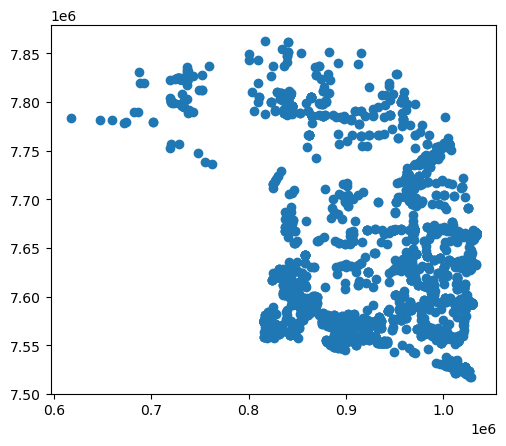

In [60]:
# Load risk surface
households_ap_gdf = gpd.read_file('raw/households/viviendas_alto_paraguay.geojson')
households_ap_gdf.to_crs(epsg=32720, inplace=True)

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(households_ap_gdf, "Boqueron households")

In [61]:
households_ap_gdf_query = generate_sql_schema(households_ap_gdf, 'ap_households')
print(households_ap_gdf_query)


-- Ap Households
CREATE TABLE ap_households (
    ap_households_id SERIAL PRIMARY KEY,
    id TEXT,
    fid INTEGER,
    DPTO TEXT,
    DPTO_DESC TEXT,
    DISTRITO TEXT,
    DIST_DESC TEXT,
    AREA TEXT,
    BAR_LOC TEXT,
    BARLO_DESC TEXT,
    geometry GEOMETRY(POINT, 32720)
);
CREATE INDEX idx_ap_households_geom ON ap_households USING GIST(geometry);



### Indigineous communities

Length of Indigineous communities GeoDataFrame: 782

Data types in Indigineous communities GeoDataFrame:
id              object
fid              int32
DPTO            object
DPTO_DESC       object
DISTRITO        object
DIST_DESC       object
AREA            object
BAR_LOC         object
BARLO_DESC      object
geometry      geometry
dtype: object
                         id  fid DPTO   DPTO_DESC DISTRITO  \
0  COMUNIDADES_INDIGENAS0.1    1   01  CONCEPCION       01   
1  COMUNIDADES_INDIGENAS0.2    2   16    BOQUERON       04   
2  COMUNIDADES_INDIGENAS0.3    3   16    BOQUERON       04   
3  COMUNIDADES_INDIGENAS0.4    4   16    BOQUERON       04   
4  COMUNIDADES_INDIGENAS0.5    5   16    BOQUERON       02   

                          DIST_DESC AREA BAR_LOC  \
0                        CONCEPCIÓN    1     023   
1                        FILADELFIA    1     004   
2                        FILADELFIA    1     005   
3                        FILADELFIA    1     006   
4  MARISCAL JOSÉ F

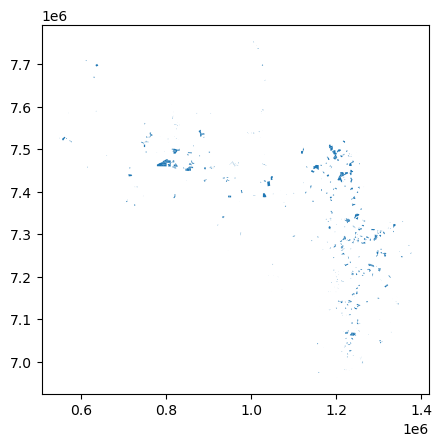

In [62]:
# Load risk surface
indig_comm_gdf = gpd.read_file('raw/indigenous_communities/comunidades_indigenas.geojson')
indig_comm_gdf.to_crs(epsg=32720, inplace=True)

# Display first 5 rows of the GeoDataFrame and get length of data
display_gdf_info(indig_comm_gdf, "Indigineous communities")

In [63]:
indig_comm_gdf_query = generate_sql_schema(indig_comm_gdf, 'indig_comm')
print(indig_comm_gdf_query)


-- Indig Comm
CREATE TABLE indig_comm (
    indig_comm_id SERIAL PRIMARY KEY,
    id TEXT,
    fid INTEGER,
    DPTO TEXT,
    DPTO_DESC TEXT,
    DISTRITO TEXT,
    DIST_DESC TEXT,
    AREA TEXT,
    BAR_LOC TEXT,
    BARLO_DESC TEXT,
    geometry GEOMETRY(MULTIPOLYGON, 32720)
);
CREATE INDEX idx_indig_comm_geom ON indig_comm USING GIST(geometry);



## Add table creation queries to `.sql` file

In [64]:
# Edit .sql file and add queries for each table
with open(r'../database/01_schema.sql', 'a') as file:
    for table_name, query in queries.items():
        file.write(query)
        file.write('\n')

# Insert data into Database

In [65]:
# Read data from $.ENV file
values = []
with open(r'..\.env', 'r') as file:
    lines = file.readlines()
    for i in lines:
        s = i.replace('\n','')
        s = s.split('=')
        if len(list(s)) > 1: # Remove titles
            values.append(s)
            
mapping = dict(values)

In [66]:
# Database connection details
db_user = mapping.get('DB_USER')
db_password = mapping.get('DB_PASS')
db_host = mapping.get('DB_HOST') # or your remote host
db_port = mapping.get('DB_PORT')      # default PostgreSQL port
db_name = mapping.get('DB_NAME')

# Create the connection URL and engine
connection_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection_url)

In [67]:
n = 0
for table in tables:
    # Insert data
    try:
        tables[table].to_postgis(
            table,
            con=engine,
            if_exists='replace', # Options: 'fail', 'replace', 'append'
            index=False          # Set to True if you want to write the DataFrame index as a column
        )
        n += 1
        print(f"{n}. Successfully uploaded data to table '{table}'")

    except Exception as e:
        print(f"An error occurred: {e}")
    

1. Successfully uploaded data to table 'chaco_boundaries'
2. Successfully uploaded data to table 'chaco_districts'
3. Successfully uploaded data to table 'fire_events'
4. Successfully uploaded data to table 'chaco_roads'
5. Successfully uploaded data to table 'chaco_rivers'
6. Successfully uploaded data to table 'chaco_protected_areas'
7. Successfully uploaded data to table 'risk_surface'
8. Successfully uploaded data to table 'pa_households'
9. Successfully uploaded data to table 'boq_households'
10. Successfully uploaded data to table 'ap_households'
11. Successfully uploaded data to table 'indig_comm'
